In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline



In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet, LassoCV, Lasso

import patsy

In [3]:
def pred_target(df):
    df.drop('Unnamed: 0', axis=1, inplace=True)
    #df = df[df.price < 400]
    
    df = df.reset_index(drop=True)
    X = df[[x for x in df.columns if x not in ['price','bhk']]]
    y = df.price.values
    target = np.log(y)
    formula = "target ~ "+' + '.join(X)+' -1'
    y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
    y = y.values.ravel()
    return X, y
    

In [4]:
copenhagen = pd.read_csv('/Users/jyots/Desktop/DS_Projects/airbnb_DataSets/Copenhagen_dfm.csv',
                   encoding='utf8')

In [5]:
copenhagen.shape

(14543, 15)

In [6]:
copenhagen = copenhagen[copenhagen['price'] < 1000]

In [7]:
X, y = pred_target(copenhagen)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [9]:
X_train.shape, X_test.shape

((10178, 22), (4363, 22))

In [10]:
linmod = LinearRegression()

In [11]:
scores = cross_val_score(linmod, X_train, y_train, cv = 10)
print scores
print np.mean(scores)
print np.std(scores)

[ 0.55585912  0.56053463  0.47235106  0.54574142  0.56534216  0.57651302
  0.57260561  0.49222332  0.44828469  0.56081013]
0.535026516126
0.0438190521879


In [12]:
predictions = cross_val_predict(linmod, X_test, y_test, cv = 10) 
accuracy = metrics.r2_score(y_test, predictions)
print accuracy


0.522686923016


In [13]:
residuals = y_test - predictions
residuals

array([ 0.89415668, -0.11555298, -0.0906    , ..., -0.19113335,
        0.69310574,  0.10744119])

In [14]:
np.mean(predictions)


4.6071663143915904

In [15]:
linmod.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
linmod.score(X_test, y_test)

0.5245986035221073

In [17]:
#linmod.coef_

In [18]:
print np.mean(y_train), np.mean(y_test)

4.617537771 4.60728985728


In [19]:
# Regularization: Gridsearch an optimal ElasticNet regression

In [20]:
Xn = StandardScaler().fit_transform(X)

In [21]:
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size = 0.3)

In [22]:
# enet_cv = ElasticNetCV(l1_ratio=np.linspace(0.01, 1., 50), n_alphas=300, cv=10, verbose=1)
# enet_cv.fit(Xn_train, y_train)


In [23]:
# print enet_cv.l1_ratio_
# print enet_cv.alpha_

In [24]:
# enet = ElasticNet(alpha= enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_)

# y_pred_enet = enet.fit(Xn_train, y_train).predict(Xn_test)
# r2_score_enet = metrics.r2_score(y_test, y_pred_enet)
# print(enet)
# print("r^2 on test data : %f" % r2_score_enet)


In [25]:
lassocv = LassoCV(n_alphas=300, cv=10)

In [26]:
lassocv.fit(Xn_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=300, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [27]:
lassocv.alpha_

0.00025339613956217884

In [28]:
lasso = Lasso(alpha=lassocv.alpha_)

y_pred_lasso = lasso.fit(Xn_train, y_train).predict(Xn_test)
r2_score_lasso = metrics.r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)


Lasso(alpha=0.00025339613956217884, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.521351


In [29]:
#np.exp(y_test).tolist()[2218]

In [30]:
tu = np.exp(y_pred_lasso).tolist()
j2 = [tu.index(i) for i in tu if i >= 350]
j2

[45, 934, 2028, 2536, 3626, 3772]

In [31]:
residuals = np.exp(y_test) - np.exp(y_pred_lasso)

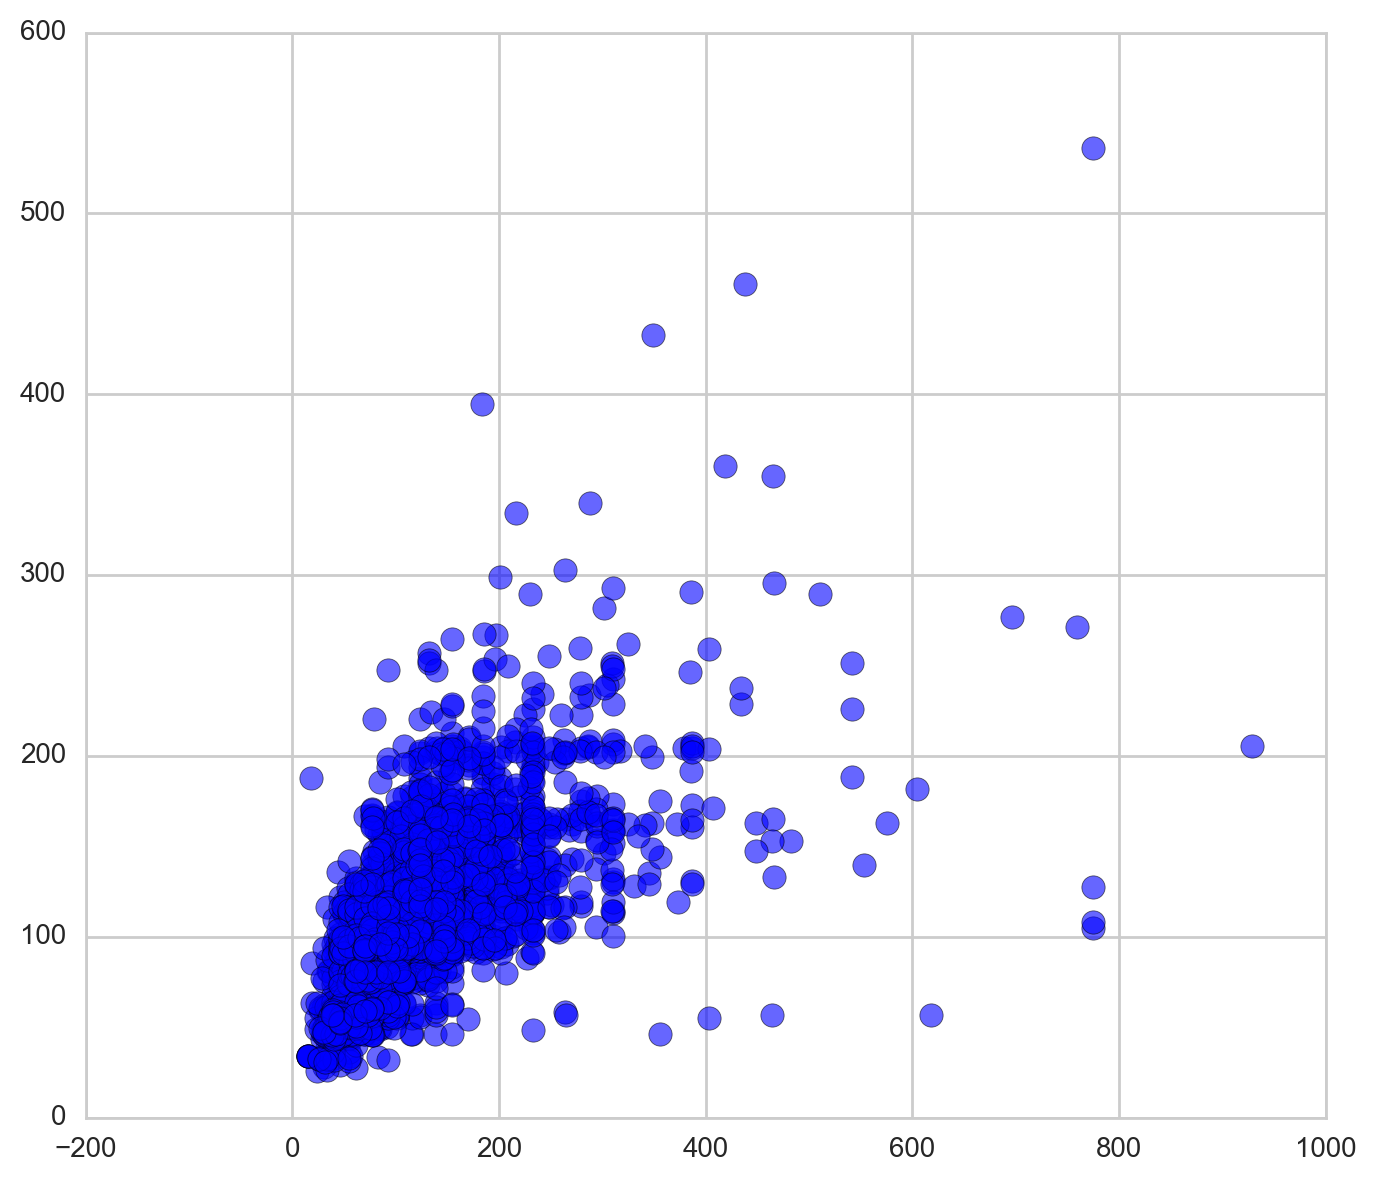

In [32]:
fig, ax = plt.subplots(figsize=(8,7))
ax.scatter(np.exp(y_test), np.exp(y_pred_lasso), s=70, alpha=0.6)
plt.show()

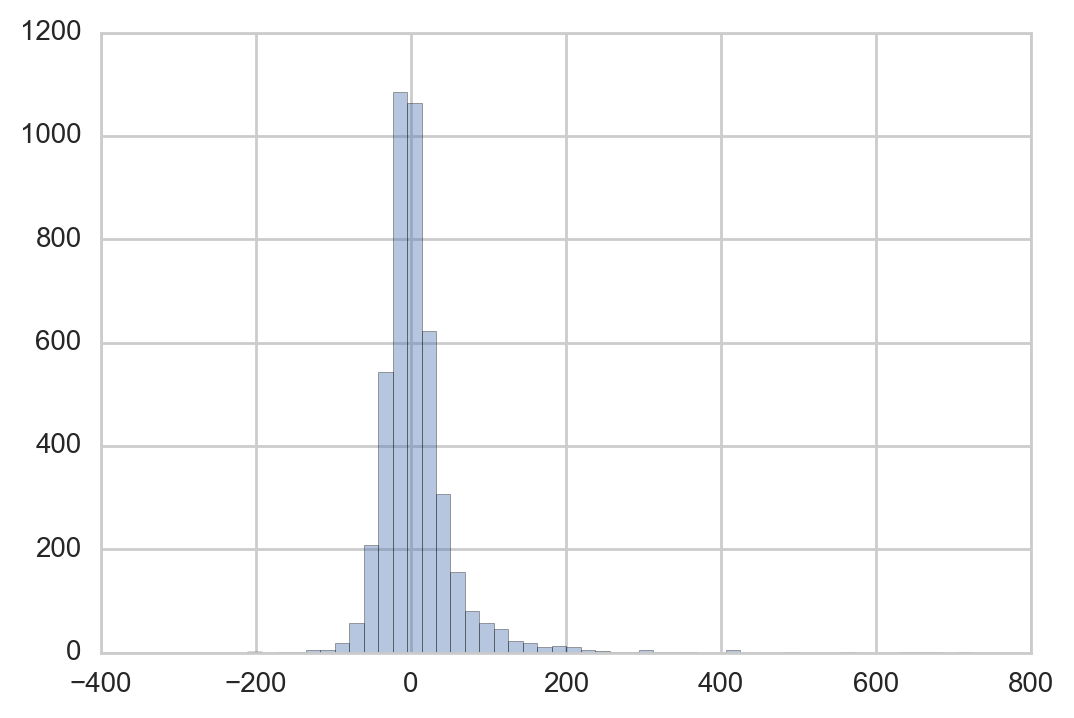

In [33]:
sns.distplot(residuals, bins=50, kde=False)

In [34]:
lasso.fit(Xn_train, y_train)

lasso_coef = pd.DataFrame({
        'variable':X_train.columns,
        'coef':lasso.coef_,
        'abscoef':np.abs(lasso.coef_)
    })

lasso_coef.sort_values('abscoef', ascending=False, inplace=True)
lasso_coef[lasso_coef.coef != 0].head(25)


,abscoef,coef,variable
13,0.187098,0.187098,bedrooms
10,0.186142,-0.186142,room_type[T.Private room]
4,0.101534,0.101534,neighborhood[Indre By]
11,0.071447,-0.071447,room_type[T.Shared room]
14,0.057581,-0.057581,dist_arprt
12,0.038308,0.038308,bathrooms
0,0.036564,-0.036564,neighborhood[Amager East]
9,0.032461,0.032461,neighborhood[Vesterbro-Kongens Enghave]
17,0.030340,-0.030340,minstay
2,0.029247,-0.029247,neighborhood[Bispebjerg]


In [35]:
# plt.plot(enet.coef_, color='lightgreen', linewidth=2,
#          label='Elastic net coefficients')
# plt.plot(lassocv.coef_, color='gold', linewidth=2,
#          label='Lasso coefficients')
# #plt.plot(linmod.coef_, '--', color='navy', label='original coefficients')
# plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
#           % (r2_score_lasso, r2_score_enet))
# plt.show()

In [36]:
lasso_coef = lasso_coef.reset_index(drop=True)


In [37]:
# linmod.fit(Xn_train, y_train)

# linmod_coef = pd.DataFrame({
#         'variable':X_train.columns,
#         'coef':linmod.coef_,
#         'abscoef':np.abs(linmod.coef_)
#     })

# linmod_coef.sort_values('abscoef', ascending=False, inplace=True)
# linmod_coef[linmod_coef.coef != 0].head(25)
# linmod_coef = linmod_coef.reset_index(drop=True)

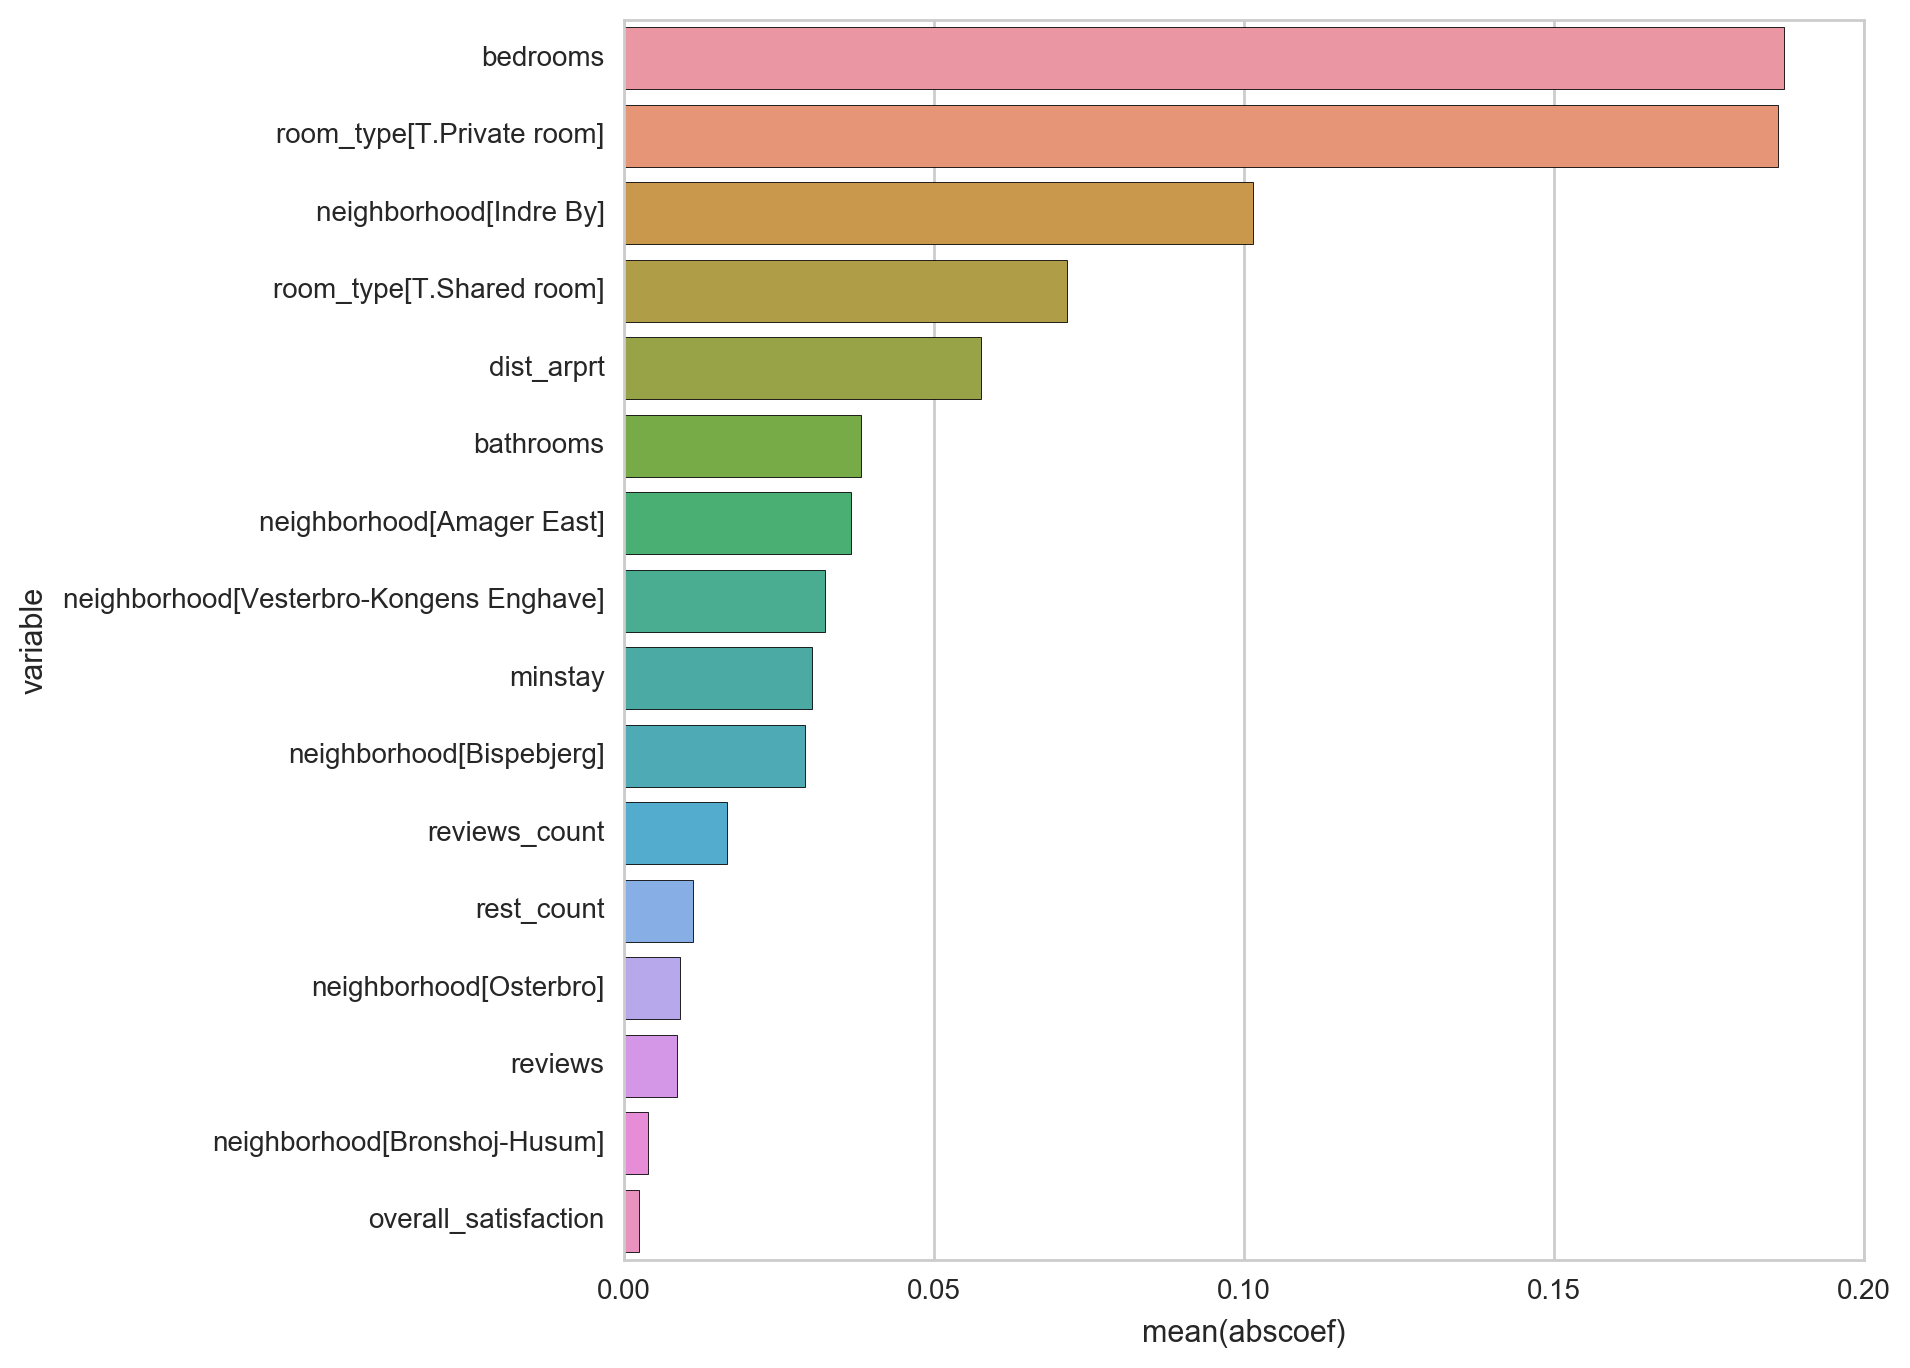

In [38]:
fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(y = lasso_coef.loc[0:15,:].variable, x = lasso_coef.loc[0:15,:].abscoef, data=lasso_coef.loc[0:15,:],
            ax=ax
           )



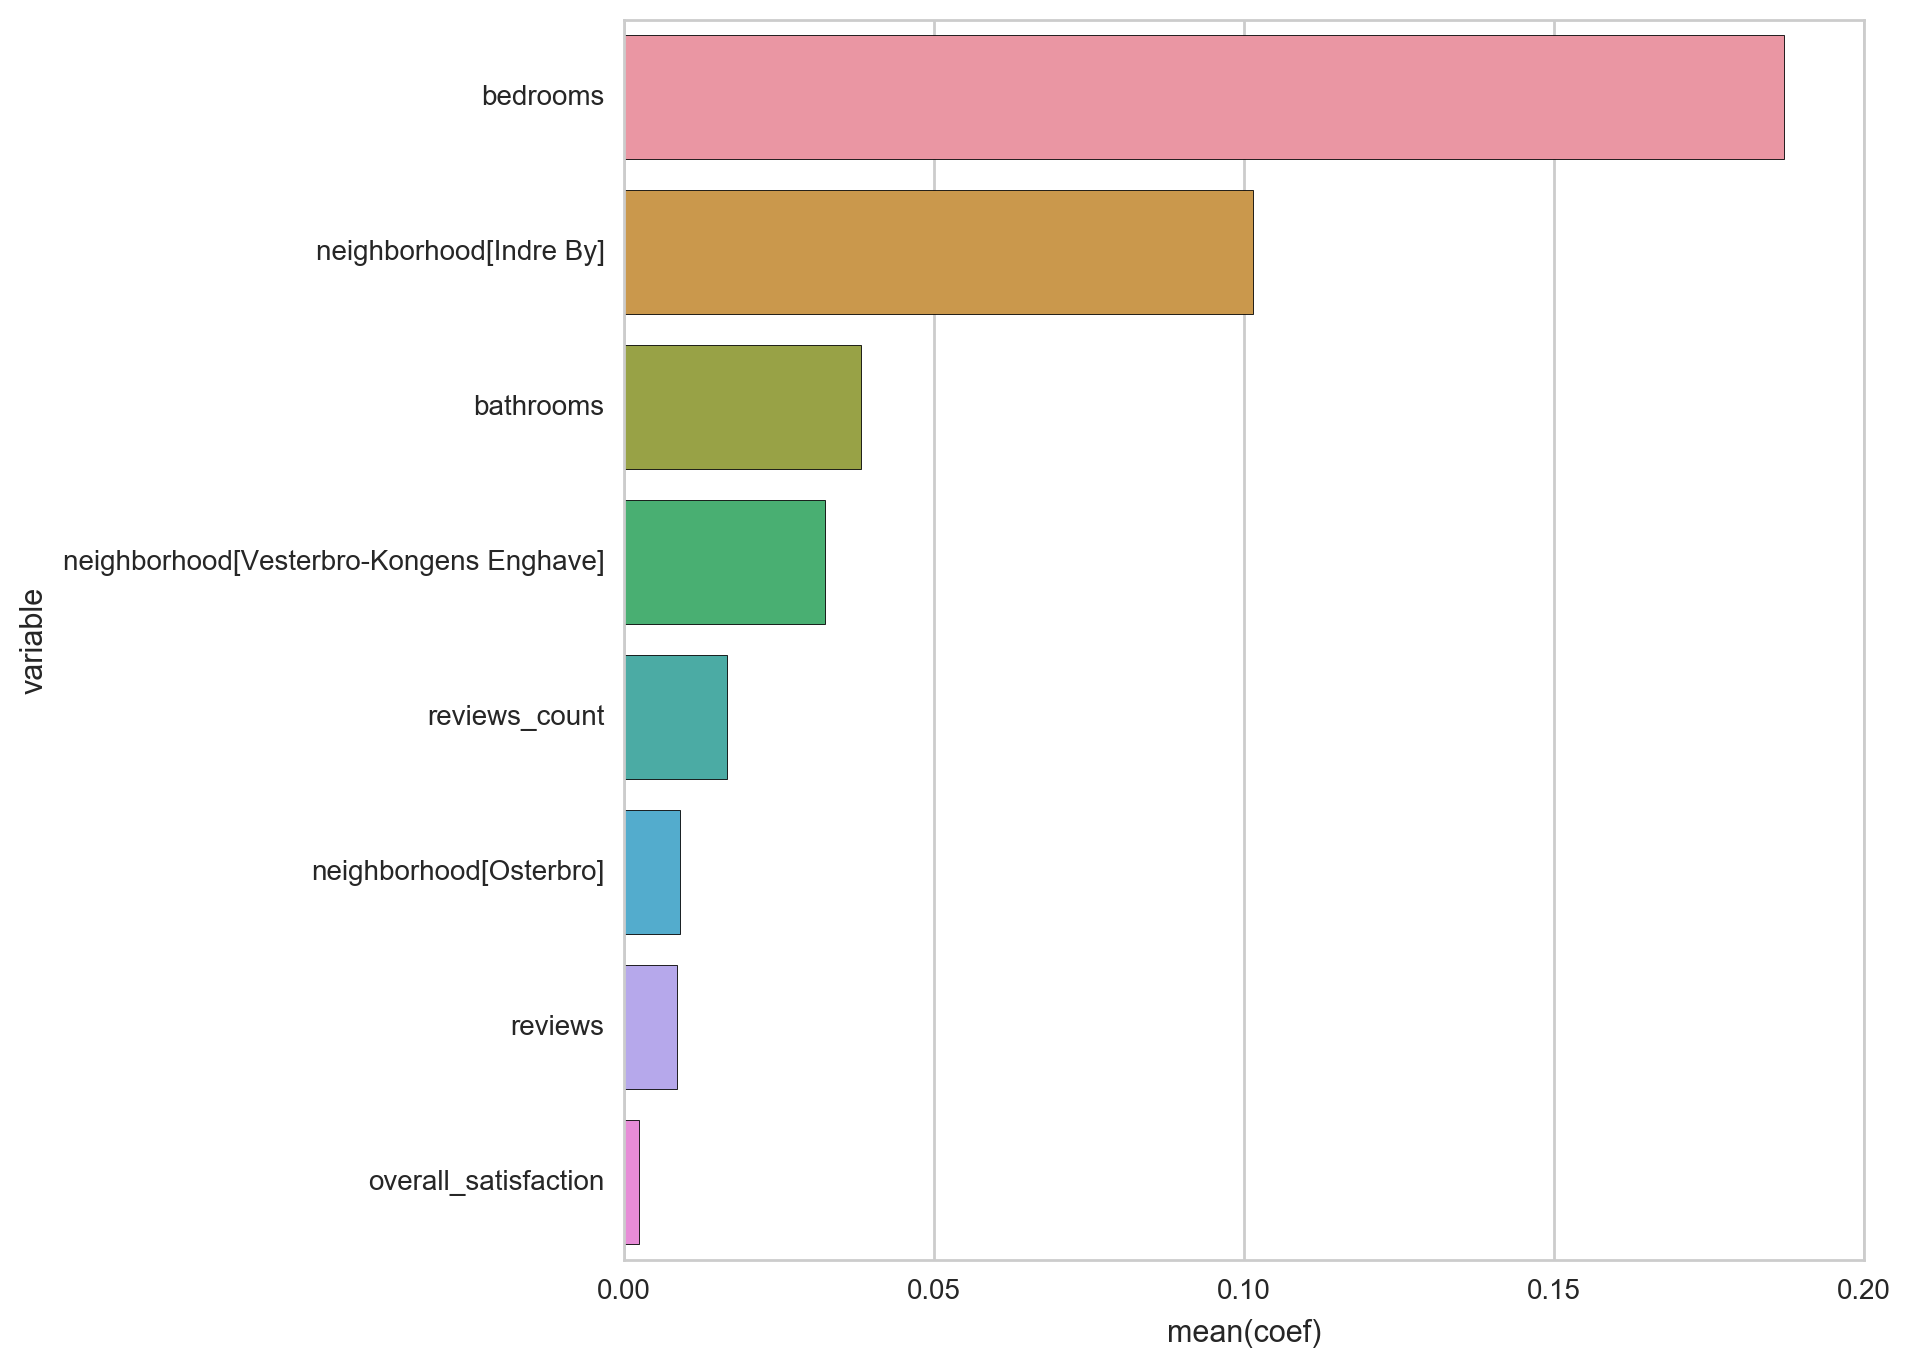

In [39]:
fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(y = lasso_coef[lasso_coef.coef > 0].variable, x = lasso_coef[lasso_coef.coef > 0].coef, data=lasso_coef,
            ax=ax
           )
plt.show()

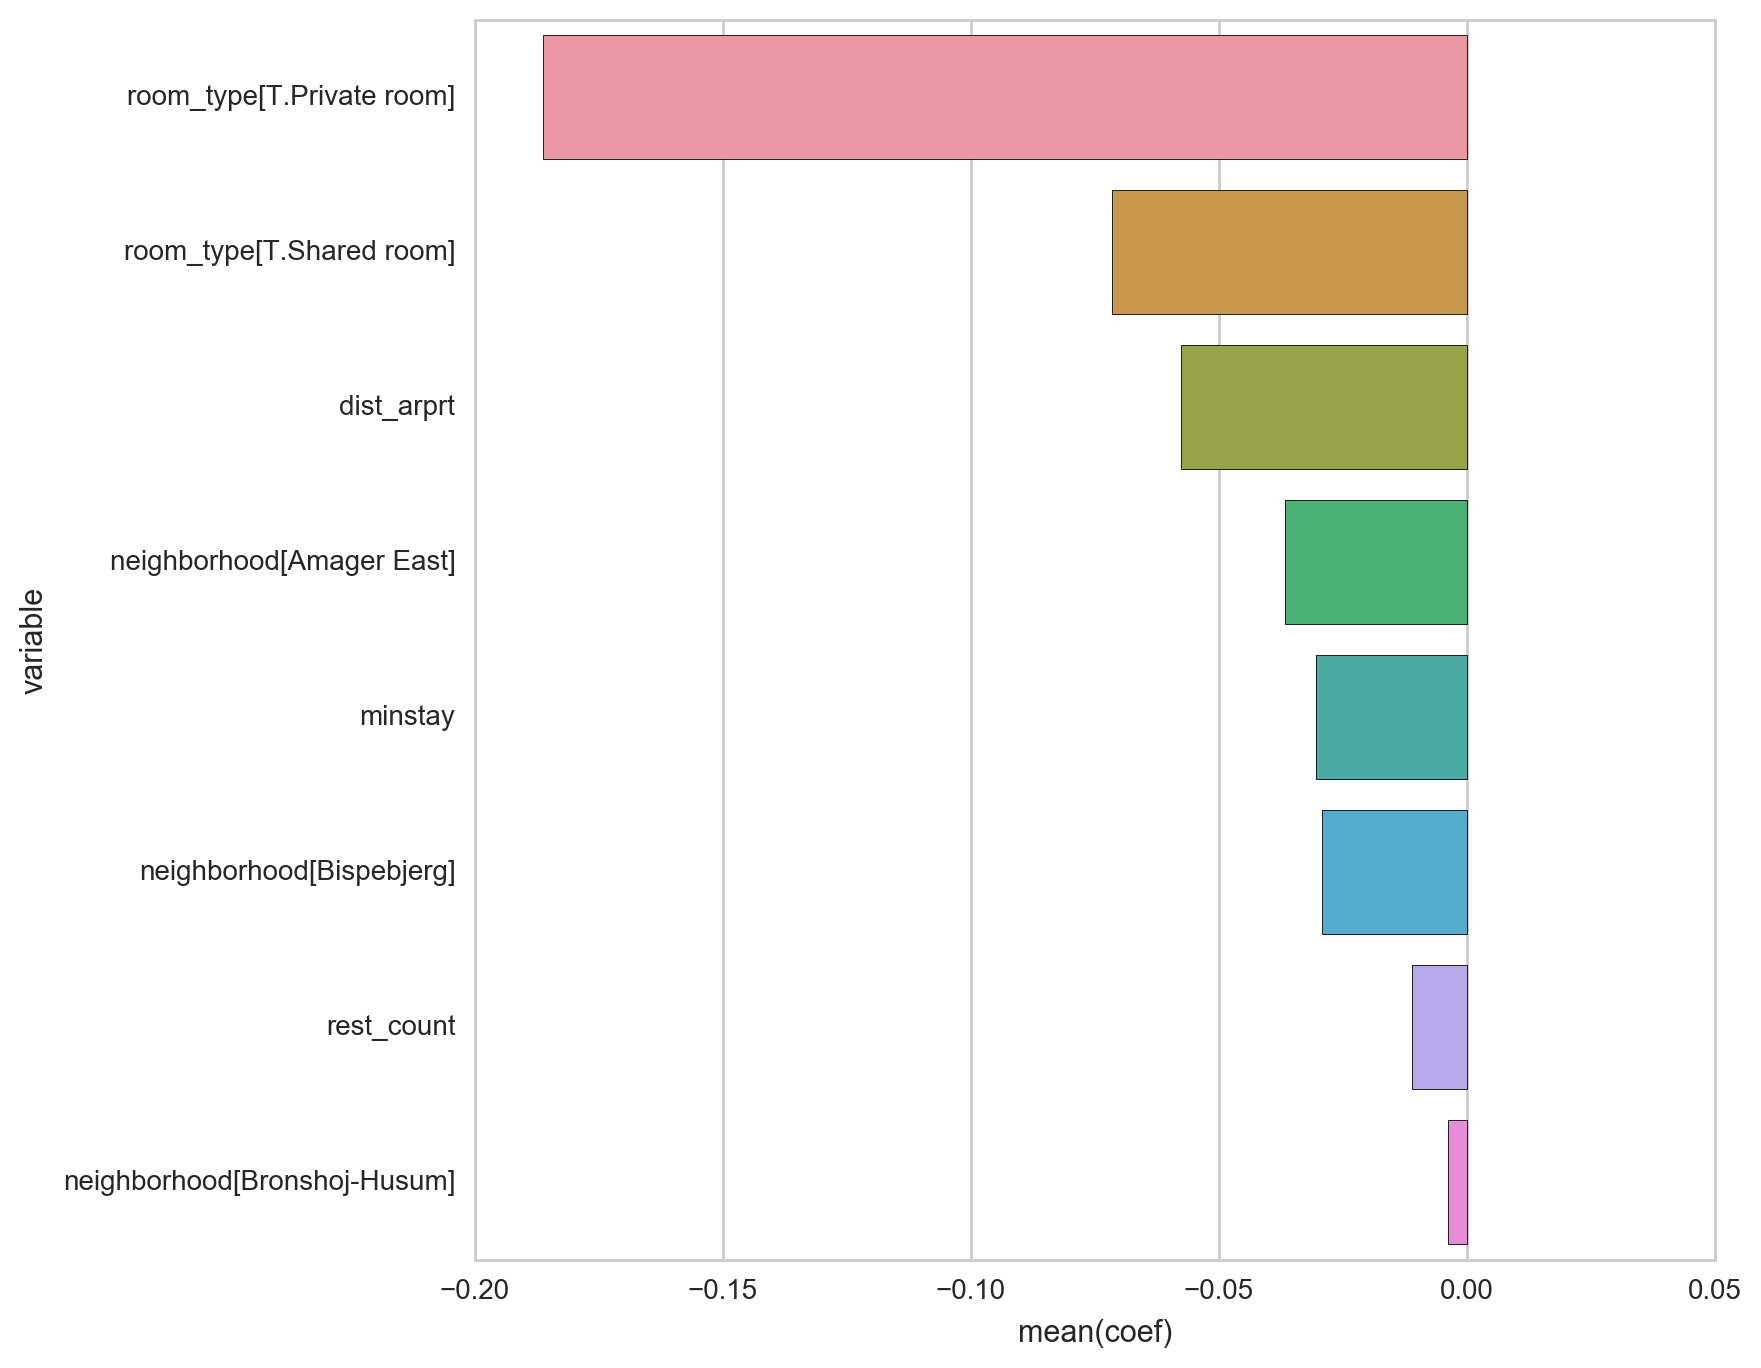

In [40]:
fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(y = lasso_coef[lasso_coef.coef < 0].variable, x = lasso_coef[lasso_coef.coef < 0].coef, data=lasso_coef,
            ax=ax
           )
plt.show()